In [ ]:
import torch
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from keyrover.datasets import *
from keyrover.ml import get_device, TexCoordsRegressionModel
from keyrover import *

In [ ]:
device = get_device()
device

In [ ]:
image_paths = get_dataset_paths()
len(image_paths)

In [ ]:
mean, std = get_dataset_norm_params(version=3)
mean, std

In [ ]:
train_paths, _, valid_paths = split_train_test_valid(image_paths, 1, 0.1)

SIZE = (256, 256)

train_dataset = KeyboardTexCoordsDataset(train_paths, size=SIZE)
valid_dataset = KeyboardTexCoordsDataset(valid_paths, size=SIZE)

len(train_dataset), len(valid_dataset)

In [111]:
# train_dataset.set_transforms([
    #     # transforms.RandomHorizontalFlip(p=0.5),
    #     # transforms.RandomVerticalFlip(p=0.5),
    #     # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    #     # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    #     # transforms.RandomErasing(p=0.5),
# ])

train_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

Mask tensor(-1.) tensor(0.9453) torch.float32 torch.Size([2, 256, 256])
Image tensor(-1.1417) tensor(2.9474)


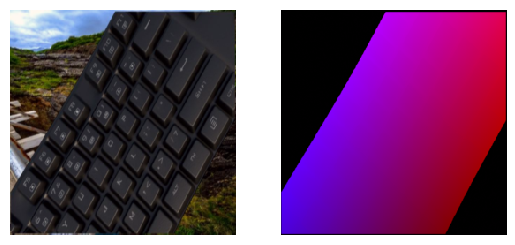

In [105]:
img, mask = train_dataset.random_img()
print("Mask", mask.min(), mask.max(), mask.dtype, mask.shape)
print("Image", img.min(), img.max())
imshow(img, mask)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": False}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)

In [ ]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

In [ ]:
ARCH = "unet"
BACKBONE = "timm-regnetx_002"

LEARNING_RATE = 2e-3

wandb.finish()
model = TexCoordsRegressionModel(ARCH, BACKBONE, in_channels=3, out_classes=2, encoder_weights="imagenet",
                                 lr=LEARNING_RATE, activation="tanh")
model

In [ ]:
summarize(model)

In [ ]:
logger = WandbLogger(project="mrover-keyboard-texcoords-segmentation")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00", callbacks=[checkpoint_callback])
wandb.define_metric(f"val_loss", summary="min")
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [112]:
torch.save(model.state_dict(), f"models/texcoords/{wandb.run.name}-{ARCH}-{BACKBONE}.pt")

tensor(-1.1417) tensor(2.9633)


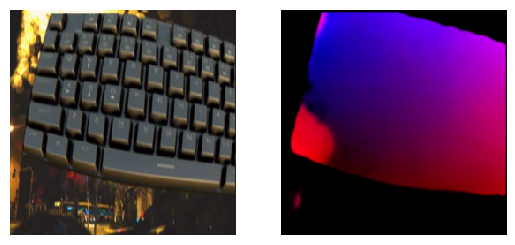

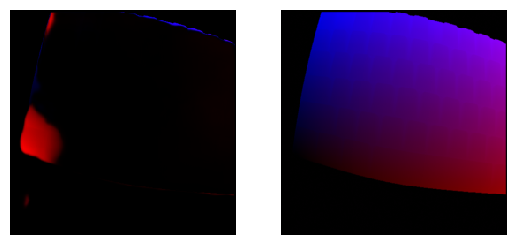

In [115]:
img, mask = valid_dataset.random_img()
pred = model.predict(model, img)

print(img.min(), img.max())

imshow(img, pred)
imshow((mask - pred) ** 2, mask)
# imshow(pred > 1)

In [ ]:
img = cv2.imread(f"datasets/test/9.jpg")

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

pred = model.predict(model, transform(img))
imshow(img, pred, figsize=(8, 8))

In [ ]:
pred.shape